In [140]:
import requests, zlib, io
import numpy as np
import pandas as pd
import multiprocessing
from urllib.parse import quote

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
url = ('http://34.90.27.133:5000', 'http://localhost:8080')[1]
data_type = ('sentences', 'paragraphs')[1]
encoders = ('w2v_lg', 'bert', 'roberta', 'distilbert', 'xlnet')
encoder = encoders[1]
encoder

'bert'

### Create dataset

In [168]:
def uncompress_numpy_array(bytestring):
    return np.load(io.BytesIO(zlib.decompress(bytestring)))

def encode(idx_text_tuple, encoder):
    idx, text = idx_text_tuple
    api_result = requests.get(f'{url}/{quote(text)}/{encoder}')
    return {'index': idx, 'feats': uncompress_numpy_array(api_result.content)}

In [173]:
def get_df(encoder):

    # read data and extract features
    data = (
        pd.read_pickle(data_type)
        .assign(undude = lambda df: df['character']!='DUDE')
        .assign(num_words = lambda df: df['text'].apply(lambda s: len(s.split())))
        [lambda df: df['num_words']>=3]
    )
    
    text_count = data['character'].value_counts()
    data = data[data['character'].isin(text_count[text_count>=10].index)].reset_index()

    idx_text_tuples = [(idx, text) for idx, text in zip(data.index, data['text'])]
    encs = [encode(idx_text_tuple, encoder) for idx_text_tuple in idx_text_tuples]

    # join data together
    return data.join(pd.DataFrame(encs).set_index('index'))

In [154]:
%%time
data = get_df(encoder)

CPU times: user 2.75 s, sys: 386 ms, total: 3.14 s
Wall time: 50.4 s


In [200]:
print(data.shape, data['feats'].iloc[0].shape)
data.sample(10)

(723, 6) (768,)


,index,character,text,undude,num_words,feats
4,4,DUDE,"Bunny? Look, moron.",False,3,"[-1.7667985, -9.282662, -7.094531, -1.578983, ..."
200,274,DUDE,"Just ask him if heask him about the car, man!",False,10,"[5.462593, -13.772672, -0.3868996, 1.7199807, ..."
90,127,DUDE,Oh shit. Walter.,False,3,"[23.029251, -11.307284, -11.23264, -10.253191,..."
152,207,DUDE,"Whose toe was it, Walter?",False,5,"[15.6297655, -21.048786, -6.171573, -6.889731,..."
327,428,WALTER,"I'm saying, Cynthia's Pomeranian. I'm looking ...",True,16,"[-5.3543286, -30.079294, -10.122738, 15.164869..."
682,837,MAUDE,"Tell me a little about yourself, Jeffrey.",True,7,"[6.463072, -20.637653, -31.18298, 4.3059015, -..."
158,214,DUDE,"All right, I'm leaving. I'm sorry ma'am.",False,7,"[2.0436, -20.14672, -17.89114, 2.1898715, -31...."
222,297,DUDE,"I want a fucking lawyer, man. I want Bill Kun...",False,10,"[-0.6696675, -19.73741, -19.090801, 20.17907, ..."
320,419,WALTER,Jeff Lebowski. Come on. This other Jeffrey L...,True,61,"[-61.783623, -67.02649, 31.209064, -13.974029,..."
114,160,DUDE,"You don't know, Walter? You seem to know the ...",False,13,"[50.994102, -35.864708, -29.091608, -15.506131..."


In [132]:
text_count = data['character'].value_counts()
data = data[data['character'].isin(text_count[text_count>=10].index)].reset_index()
data['character'].value_counts().to_frame(name='character_counts').T

,DUDE,WALTER,MAUDE,LEBOWSKI,BRANDT,DONNY,THE STRANGER,TREEHORN
character_counts,308,226,49,41,36,35,17,11


In [177]:
all_data = {encoder: get_df(encoder) for encoder in encoders}

In [157]:
# # use one-hot-enc as labels
# one_hot = OneHotEncoder().fit(data['character'].values.reshape(-1,+1))
# Y = one_hot.transform(data['character'].values.reshape(-1,+1)).todense()

### Dude / UnDude

In [184]:
stress_talk_idx = data['text'].str.contains('Her life was in our hands') | data['text'].str.contains('We\'re screwed now')
data.loc[stress_talk_idx]

,index,character,text,undude,num_words,feats
91,128,DUDE,"They hung up, Walter! You fucked it up! You ...",False,18,"[0.42279857, -23.982761, -45.342335, -40.44201..."
92,129,DUDE,We're screwed now! We don't get shit and they...,False,15,"[12.343807, -27.609848, 13.977277, 21.82332, -..."


In [178]:
model = SVC(gamma='scale')
model = MLPClassifier()
model = LogisticRegressionCV(cv=3, max_iter=1000, solver='lbfgs')
pp = StandardScaler() # PCA(n_components=0.95)

stress_talk_idx = (
    data['text'].str.contains('Her life was in our hands') | 
    data['text'].str.contains('We\'re screwed now')
)

res = []
splits = StratifiedKFold(n_splits=10)

for encoder, data in all_data.items():

    # concatenate features
    X = np.zeros((len(data), len(data['feats'].iloc[0])))
    for i in range(len(X)):
        X[i,:] = data['feats'].iloc[i]

    accuracies = []
    for train_idx, test_idx in splits.split(X, data['undude']):

        if pp:
            X_train = pp.fit_transform(X[train_idx])
            X_test = pp.transform(X[test_idx])
        else:
            X_train = X[train_idx]
            X_test = X[test_idx]

        model.fit(X_train, data.loc[train_idx, 'undude'])
        P = model.predict(X_test)
        T = data.loc[test_idx, 'undude']
        accuracies.append(accuracy_score(T, P))

#         cm = confusion_matrix(T, P)
#         single_confmat = cm if single_confmat is None else cm+single_confmat

    undudeness = (
        model
        .fit(pp.fit_transform(X[~stress_talk_idx]), data.loc[~stress_talk_idx, 'undude'])
        .predict(pp.transform(X[stress_talk_idx]))
    )
    
    res.append({
        'encoder': encoder,
        'accuracy': np.mean(accuracies),
        'accuracy_std': np.std(accuracies),
        'unDude_1': undudeness[0],
        'unDude_2': undudeness[1]
    })
    print(res[-1])

res = pd.DataFrame(res)
res

{'encoder': 'w2v_lg', 'accuracy': 0.5989251720367869, 'accuracy_std': 0.04502431958155923, 'unDude_1': True, 'unDude_2': False}
{'encoder': 'bert', 'accuracy': 0.6754346474585718, 'accuracy_std': 0.08200136556644616, 'unDude_1': False, 'unDude_2': True}
{'encoder': 'roberta', 'accuracy': 0.6435837245696401, 'accuracy_std': 0.05769195740855355, 'unDude_1': True, 'unDude_2': True}
{'encoder': 'distilbert', 'accuracy': 0.6682222329410251, 'accuracy_std': 0.04475200700834805, 'unDude_1': True, 'unDude_2': True}
{'encoder': 'xlnet', 'accuracy': 0.5948324651102965, 'accuracy_std': 0.04628671311100907, 'unDude_1': False, 'unDude_2': False}


,encoder,accuracy,accuracy_std,unDude_1,unDude_2
0,w2v_lg,0.598925,0.045024,True,False
1,bert,0.675435,0.082001,False,True
2,roberta,0.643584,0.057692,True,True
3,distilbert,0.668222,0.044752,True,True
4,xlnet,0.594832,0.046287,False,False


In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

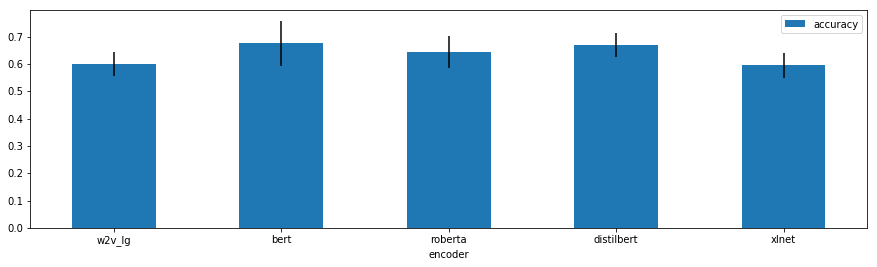

In [209]:
plt.rcParams['figure.figsize'] = 15, 4
res.plot.bar(x='encoder', y='accuracy', yerr='accuracy_std', rot=0)

In [210]:
res[['encoder', 'unDude_1', 'unDude_2']]

,encoder,unDude_1,unDude_2
0,w2v_lg,True,False
1,bert,False,True
2,roberta,True,True
3,distilbert,True,True
4,xlnet,False,False
